# Building an Agent with LangGraph
- Author: [Erika Park](https://www.linkedin.com/in/yeonseo-park-094193198/)
- Designer: [Erika Park](https://www.linkedin.com/in/yeonseo-park-094193198/)
- Peer Review: 
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/05-Using-OpenAIAPI-MultiModal.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/05-Using-OpenAIAPI-MultiModal.ipynb)


## Overview

In this tutorial, we will enhance a chatbot by integrating a web search tool, enabling it to perform web searches as part of its functionality. This integration allows the chatbot to retrieve up-to-date information from the web, making its responses more accurate and dynamic.

**Key Objectives**

1. Web Search Tool Integration: <br>
* We will construct an agent that binds a web search tool to an LLM (Large Language Model). The agent will intelligently decide when to invoke the web search tool based on the user’s input.

2. Conditional Routing Using Edges: <br>
* Learn how to use conditional edges to route the workflow to different nodes based on whether the web search tool is invoked. This ensures efficient handling of requests that may or may not require external information.
<br>

By the end of this tutorial, you will understand how to integrate a web search tool with an LLM and create a chatbot capable of leveraging real-time web data effectively.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Using Tools](#using-tools)
- [Tool Node](#tool-node)
- [Conditional Edge](#conditional-edge)

### References 
- [TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)
- [How to visualize your graph](https://langchain-ai.github.io/langgraph/how-tos/visualization/)
 
<br>

---


## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions, and utilities for tutorials. 
- You can check out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain_community",
        "langchain_openai",
        "langchain_core",
        "langgraph",
        "langsmith"
    ],
    verbose=False,
    upgrade=False,
)


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        # "OPENAI_API_KEY": "",
        # "LANGCHAIN_API_KEY": "",
        # "TAVILY_API_KEY":"",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Agent-with-LangGraph",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Configuration file to manage the API KEY as an environment variable
from dotenv import load_dotenv

# Load API KEY information
load_dotenv(override=True)

True

## Using Tools

To address questions that a chatbot cannot answer from "memory," we will integrate a web search tool. This tool will enable the chatbot to retrieve relevant information and provide more accurate and informed responses.

For this tutorial, we will use the Tavily Search API to implement search functionality. This API provides two primary classes: `TavilySearchResults` and `TavilyAnswer` .

### Tavily Search API Tool
The Tavily Search API tool is designed to facilitate powerful search capabilities within the chatbot. It retrieves comprehensive and reliable search results, making it ideal for answering questions about current events or topics that require external information.

**API Key Setup**
1. Obtain an API key from the following link: [Tavily API Key Issuance](https://app.tavily.com/).
2. Set the API key as an environment variable in your project.
Create a `.env` file in the project directory and include the API key as shown below:

```
TAVILY_API_KEY=tvly-abcdefghijklmnopqrstuvwxyz
```

**TavilySearchResults Class**

- This class queries the Tavily Search API and returns results in JSON format.
- It is optimized for delivering comprehensive, accurate, and reliable search results.
- Particularly useful for addressing questions related to ongoing events or recent updates.


1. **Import and Create the Search Tool**

In [5]:
from langchain_community.tools import TavilySearchResults

# Create the Search Tool
tool = TavilySearchResults(
    max_results=3,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)

**2. Add the Tool to the Tool List**

* The search tool is added to a list ( `tools` ). In LangChain, multiple tools can be combined to build more advanced workflows.

In [6]:
tools = [tool]

**3. Execute the Tool**

- The `invoke` method is called to execute the search query "U.S. Presidential Inauguration".
The search results are returned in JSON format and displayed using the `print` statement.
- The results are page summaries that can be used by the chatbot to answer user questions.

In [16]:
print(tool.invoke("U.S. Presidential Inauguration"))

[{'url': 'https://www.britannica.com/topic/United-States-presidential-inauguration', 'content': 'After the worship services, the president-elect and vice president-elect—as well as family members and various public officials, almost always including the current president and vice president—have proceeded to the U.S. Capitol for the swearing-in ceremonies. The vice president-elect is sworn in first, often by an official of his or her choosing, and then the president-elect is sworn in, typically by the chief justice of the Supreme Court. After taking the oath of office, the new president gives an inaugural address expressing a vision of the country’s future and the goals of the new administration. If January 20 falls on a Sunday, the president is inaugurated that day in a small ceremony, with a public inauguration and the subsequent festivities being held the next day. The inauguration of Joe Biden in 2021 took place amid a public health emergency, the COVID-19 pandemic, and followed by 

### Adding bind_tools to Configure LLM + Tools

In this section, we will integrate `bind_tools` into the LLM to enable **LLM + Tools** functionality. 

This allows the LLM to leverage external tools dynamically and respond more effectively to user inputs.



**1. Define the State Schema**

- The `State` class acts as the schema for storing and passing the graph's state to the next node.
- Using Python's `TypedDict` and annotations, we define the `messages` property as a list that supports adding new messages via the `add_messages` function from `LangGraph` .
- While the schema can support additional state properties, this tutorial focuses solely on `messages` .

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# Define State Schema
class State(TypedDict):
    # Apply add_messages to the list type to enable message addition
    messages: Annotated[list, add_messages]

**2. Initialize the LLM and Bind Tools**

- The `ChatOpenAI` instance is initialized as the LLM. 
- The `bind_tools` method is then used to attach a set of tools to the LLM, enabling it to invoke external functionality.

 By binding the custom tool we created, the LLM gains the ability to perform web searches, adding responsive capabilities to the chatbot.

In [9]:
from langchain_openai import ChatOpenAI

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

**3. Define a Node Function**

- Nodes are the building blocks of the graph. 
- Each node represents a specific operation or step in the process. 
- Here, we define a node function `chatbot` that uses the `llm_with_tools` instance to process the incoming `messages` from the `State` and returns the updated list of messages.

Since the `add_messages` functionality is already applied, if the tool is deemed necessary during processing, the result of the tool call is stored in `answer` . This result is then accumulated in `messages` through the `add_messages` method, maintaining an updated conversation flow.


In [10]:
# Define Node Function
def chatbot(state: State):
    # Invoke LLM with tools using the provided messages
    answer = llm_with_tools.invoke(state["messages"])
    # Return updated messages (add_messages applied automatically)
    return {"messages": [answer]}

**4. Create a Graph and Add Nodes**

- Create a  `StateGraph` instance to represent the workflow and add the `chatbot` node to it. 

In [11]:
from langgraph.graph import StateGraph

# Initialize the State Graph with the defined State schema
graph_builder = StateGraph(State)

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

## Tool Node

Next, we need to create a function that will execute the tool whenever it is invoked. 

To achieve this, we will add a new node specifically designed for tool execution.

We’ll implement a custom `BasicToolNode` that checks the most recent message. 
If the message includes `tool_calls` , the node will execute the corresponding tool. 

While we are implementing this manually for now, it’s worth noting that later on, you can replace this with LangGraph's pre-built [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) for greater convenience.

In [12]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # List of tools
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # Extract the most recent message if messages exist
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # Results from tool calls
        outputs = []
        for tool_call in message.tool_calls:
            # Call the tool and store the result
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # Store the tool call result as a message
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # Convert tool call result to a string
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# Create a tool node
tool_node = BasicToolNode(tools=[tool])

# Add the tool node to the graph
graph_builder.add_node("tools", tool_node)

 **Explanation of the Code**

1. **Purpose of the Code**
   - This code defines a tool node ( `BasicToolNode` ) that dynamically executes tools based on instructions from the most recent message in a list of inputs.

2. **How It Works**
   - **Initialization ( `__init__` )**: 
     - A list of tools is passed to the `BasicToolNode` constructor. 
     - Each tool is stored in a dictionary for quick lookup by name.
   - **Execution ( `__call__` )**:
     - When the node is called, it looks at the most recent message in the provided input (`messages` key).
     - It extracts the tool calls from the message and invokes the appropriate tools using their names and arguments.
     - The results are formatted as `ToolMessage` objects and returned.

3. **ToolMessage**
   - A `ToolMessage` is a standardized way to store and return tool execution results, including the tool name, result content, and a unique ID for the tool call.

4. **Adding to a Graph**
   - The tool node ( `tool_node` ) is added to a graph using `graph_builder.add_node` . This integrates the node into a larger workflow or execution pipeline.

5. **Usage**
   - This structure is typically part of a larger system where tools are invoked based on user input or system logic, and results are returned to the user or passed along to other nodes.


## Conditional Edge

Once the tool node is added, you can define `conditional_edges` to control the flow of execution in the graph.
- Edges: They route the control flow from one node to the next in a graph.
- Conditional Edges: These are edges with "if" logic that determine the next node based on the current graph state. These functions take the current graph `state` as input and return the name of the next node (or a list of nodes).

In the example below, we define a router function `route_tools` that inspects the chatbot's output for `tool_calls`.

This function is passed to the graph using `add_conditional_edges` . Every time the `chatbot` node completes execution, the function determines where to go next:
- If there is a tool call, it routes to the `tools` node.
- If there is no tool call, it routes to the `END` node, terminating the flow.

This can be replaced with the pre-built [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) available in LangGraph.

### add_conditional_edges method


<img src="./assets/03-langgraph-agent-conditional-edge.png" width="500" />


The `add_conditional_edges` method adds conditional logic to the graph. Here's a breakdown of its parameters and functionality:

**Parameters**
- `source` ( `str` ): The starting node where the conditional edge originates.
- `path` ( `Callable` ): A function or callable object that determines the next node(s). It takes the current state as input and returns one or more node names.
- `path_map` ( `dict` or `list` ): Maps the output of `path` to specific nodes in the graph. If omitted, the output of `path` must directly correspond to node names.
- `then` ( `Optional[str]` ): Specifies the node to execute after the node selected by path.
  
**Return Value**
- Returns the graph object itself for method chaining.

**Key Features of `add_conditional_edges`**
- Dynamic Flow Control: Allows you to define logic that dynamically alters the flow based on the state.

- Path Mapping: Converts the output of the `path` function into specific graph nodes.

- Error Handling: Raises `ValueError`  if:
    - The `path` function lacks a type hint or `path_map` .
    - A branch with the same name already exists.
- Graph Visualization: Once the graph is defined, it can be visualized using the following method.

In [13]:
from langgraph.graph import START, END

# Define the router function
def route_tools(state: State):
    if messages := state.get("messages", []):
        # Extract the most recent AI message
        ai_message = messages[-1]
    else:
        # Raise an error if no messages are found
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # Check for tool calls in the AI message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If there are tool calls, route to "tools"
        return "tools"
    # If no tool calls, route to "END"
    return END

# Add conditional edges to the graph
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # Map the returned values to specific nodes
    path_map={"tools": "tools", END: END},
)

# Define additional edges
graph_builder.add_edge("tools", "chatbot")  # Return to chatbot after tools
graph_builder.add_edge(START, "chatbot")    # Start with the chatbot node

# Compile the graph
graph = graph_builder.compile()


Conditional Edges must originate from a single node.

In this example, whenever the `chatbot` node is executed, the graph logic checks for tool calls:

- If tool calls are present, the flow transitions to the `tools` node for further processing.
- If no tool calls are present, the flow ends, effectively terminating the loop.
  
Similar to the pre-built `tools_condition` , the custom function returns the string `END` when there are no tool calls. When the graph transitions to END, no further tasks are executed, and the process halts.

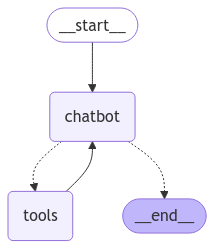

In [14]:
graph

Now, the bot can handle questions outside its training data.

In [15]:
inputs = {"messages": "Search for information about the TED YouTube channel"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='Search for information about the TED YouTube channel' additional_kwargs={} response_metadata={} id='e0095406-2596-456b-a3a6-abcb6c42cc6f'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_RKDB4rBbT5SeCfPkGDvhLeCZ', 'function': {'arguments': '{"query":"TED YouTube channel"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-b67c6264-758e-4946-bdeb-43bc60f04e88-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'TED YouTube channel'}, 'id': 'call_RKDB4r

### Illustration of the structure after a tool call

This diagram illustrates the structure of a "Tool Message" in a chatbot workflow, showing how tool-related data (such as tool calls, arguments, and metadata) is organized and recorded during the tool invocation process. 

![Illustration of the structure after a tool call](./assets/03-langgraph-agent-diagram.png)